# Least Squares Polynomial Regression with Cross-validation (CV)

Example of least squares polynomial regression applied over varying degrees $d$, with K-fold cross-validation (CV) performed to select the best degree according to a validation set.

In [1]:
# Widget to manipulate plots in Jupyter notebooks
%matplotlib widget 

from math import ceil, floor

import matplotlib.pyplot as plt # For general plotting
import matplotlib.colors as mcol
from matplotlib.ticker import MaxNLocator

import numpy as np

from scipy.stats import multivariate_normal as mvn
from sklearn.preprocessing import PolynomialFeatures # Important new include
from sklearn.model_selection import KFold # Important new include

np.set_printoptions(suppress=True)

# Set seed to generate reproducible "pseudo-randomness" (handles scipy's "randomness" too)
np.random.seed(7)

plt.rc('font', size=22)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=22)   # fontsize of the figure title

## Polynomial Linear Regression

Given a dataset, $\mathcal{D} = \{(\mathbf{x}^{(i)}, y^{(i)}) \}_{i=1}^N$, with $N$ examples of input $\mathbf{x} \in \mathbb{R}^n$ and output $y \in \mathbb{R}$ pairs, we can assume a least squares linear regression model with residual sum of squares (RSS) loss $\mathcal{L}_\text{RSS}(\boldsymbol{\theta})$:

\begin{equation*}
\mathcal{L}_\text{RSS}(\boldsymbol{\theta}) = \sum_{i=1}^N (\hat{y}^{(i)} - y^{(i)})^2 = \sum_{i=1}^N (\mathbf{\theta}^\intercal \mathbf{\tilde{x}}^{(i)} - y^{(i)})^2,
\end{equation*}

where $\hat{y}^{(i)} \in \mathbb{R}$ is our prediction and $\mathbf{\tilde{x}}^{(i)} = \begin{bmatrix}1 & \mathbf{x}\end{bmatrix}^\intercal \in \mathbb{R}^{(n+1)}$ the augmented input vector for sample/example $i$, while $\boldsymbol{\theta} = \begin{bmatrix} w_0 \mathbf{w}\end{bmatrix}^\intercal \in \mathbb{R}^{(n+1)}$ is our parameter vector that contains the bias term $w_0$ and regression coefficients/weights $\mathbf{w}$.

As we have discussed in class, a straight line is unlikely to fit a complex, non-linear dataset very well. However, we can apply a <b>fixed</b> non-linear transformation to the input features $\phi(\mathbf{x})$ as follows: 

\begin{equation*}
\mathcal{L}_\text{RSS}(\boldsymbol{\theta}) = \sum_{i=1}^N (\hat{y}^{(i)} - y^{(i)})^2 = \sum_{i=1}^N (\boldsymbol{\theta}^\intercal \phi(\mathbf{\tilde{x}}^{(i)}) - y^{(i)})^2,
\end{equation*}

A fixed transformation allows the model to remain linear in the parameter space, unlike neural networks where the transformation is also parameterized $\phi(\mathbf{x}; \boldsymbol{\theta})$ and updated during model fitting.

The analytical solution (normal equation) to this model, also the <b>maximum likelihood estimate (MLE)</b> assuming fixed variance (homoscedasticity), is: 

\begin{equation*}
\boldsymbol{\theta}^* = (\mathbf{X}^\intercal\mathbf{X})^{-1}\mathbf{X}^\intercal \mathbf{y}
\end{equation*}

The Mean Squared Error (MSE) loss function $\mathcal{L}_\text{MSE}(\boldsymbol{\theta})$ is typically viewed as the RSS loss above, but scaled by $\frac{1}{N}$, i.e., taking the average:

$$\mathcal{L}_\text{MSE}(\boldsymbol{\theta}) = \frac{1}{N}\mathcal{L}_\text{RSS}(\boldsymbol{\theta}).$$

Below is an implementation of basis expansion on inputs for arbitrary order $d$, as well as the normal equation for least squares and MSE:

In [2]:
# Forms a Vandermonde matrix with N values in x up to polynomial power d
def phi_transformation(X, d):
    # Repeat the array d number of times 
    X_d = np.tile(X, d)
    # Get evenly space values from 1 to d
    n_d = np.arange(d) + 1
    # Get the corresponding matrix of degrees to apply to each n-dimensional input in the dataset
    # First repeat each degree value per dimension for all x_i^d given a particular sample i
    # Then reshape the flattened vector into the original matrix shape, with -1 to adapt the number of columns
    degs = np.tile(np.repeat(n_d, X.shape[1]), X.shape[0]).reshape(X.shape[0], -1)
    # Compute polynomial powers given degrees matrix
    X_poly = np.power(X_d, degs)
    return X_poly


# Analytical optimal solution, aka the normal equation for least squares
# Fit order d polynomial usins training data set with MLE method which
# reduces to least-squares curve fitting here due to additive Gaussian noise
def mle_solution(X, y):
    # Model: y = phi(X)^T*theta
    # LS estimate: theta^* = (phi(X)^T*phi(X))^-1 * phi(X)^T * y 
    return np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)


def mse(y_preds, y_true):
    # Residual error (X * theta) - y
    error = y_preds - y_true
    # Loss function is MSE
    return np.mean(error ** 2)

Let's use the data-generating function from HW2 Q2 for this example:

In [3]:
def hw2_q2(N, dataset_name):
    gmm_pdf = {}
    gmm_pdf['priors'] = np.array([.3, .4, .3])
    gmm_pdf['mu'] = np.array([[-10, 0, 10], [0, 0, 0], [10, 0, -10]])  # Gaussian distributions means
    gmm_pdf['Sigma'] = np.array([[[1, 0, -3], [0, 1, 0], [-3, 0, 15]], [[8, 0, 0], [0, .5, 0], [0, 0, .5]],
                                 [[1, 0, -3], [0, 1, 0], [-3, 0, 15]]])  # Gaussian distributions covariance matrices

    X, y = generate_gmm_data(N, gmm_pdf)

    # Plot the original data and their true labels
    fig = plt.figure(figsize=(10, 10))

    ax_raw = fig.add_subplot(111, projection='3d')

    ax_raw.scatter(X[:, 0], X[:, 1], y, marker='o', color='b')
    ax_raw.set_xlabel(r"$x_1$")
    ax_raw.set_ylabel(r"$x_2$")
    ax_raw.set_zlabel(r"$y$")
    # Set equal axes for 3D plots
    ax_raw.set_box_aspect((np.ptp(X[:, 0]), np.ptp(X[:, 1]), np.ptp(y)))

    plt.title("{} Dataset".format(dataset_name))
    plt.tight_layout()
    plt.show()

    return X, y


def generate_gmm_data(N, gmm_pdf):
    # Generates N vector samples from the specified mixture of Gaussians
    # Returns samples and their component labels
    # Data dimensionality is determined by the size of mu/Sigma parameters

    # Decide randomly which samples will come from each component
    u = np.random.random(N)
    thresholds = np.cumsum(gmm_pdf['priors'])
    thresholds = np.insert(thresholds, 0, 0)  # For intervals of classes

    n = gmm_pdf['mu'].shape[0]  # Data dimensionality

    X = np.zeros((N, n))
    C = len(gmm_pdf['priors'])  # Number of components
    for i in range(C + 1):
        # Get randomly sampled indices for this Gaussian, checking between thresholds based on class priors
        indices = np.argwhere((thresholds[i - 1] <= u) & (u <= thresholds[i]))[:, 0]
        # No. of samples in this Gaussian
        X[indices, :] = mvn.rvs(gmm_pdf['mu'][i - 1], gmm_pdf['Sigma'][i - 1], len(indices))

    return X[:, 0:2], X[:, 2]

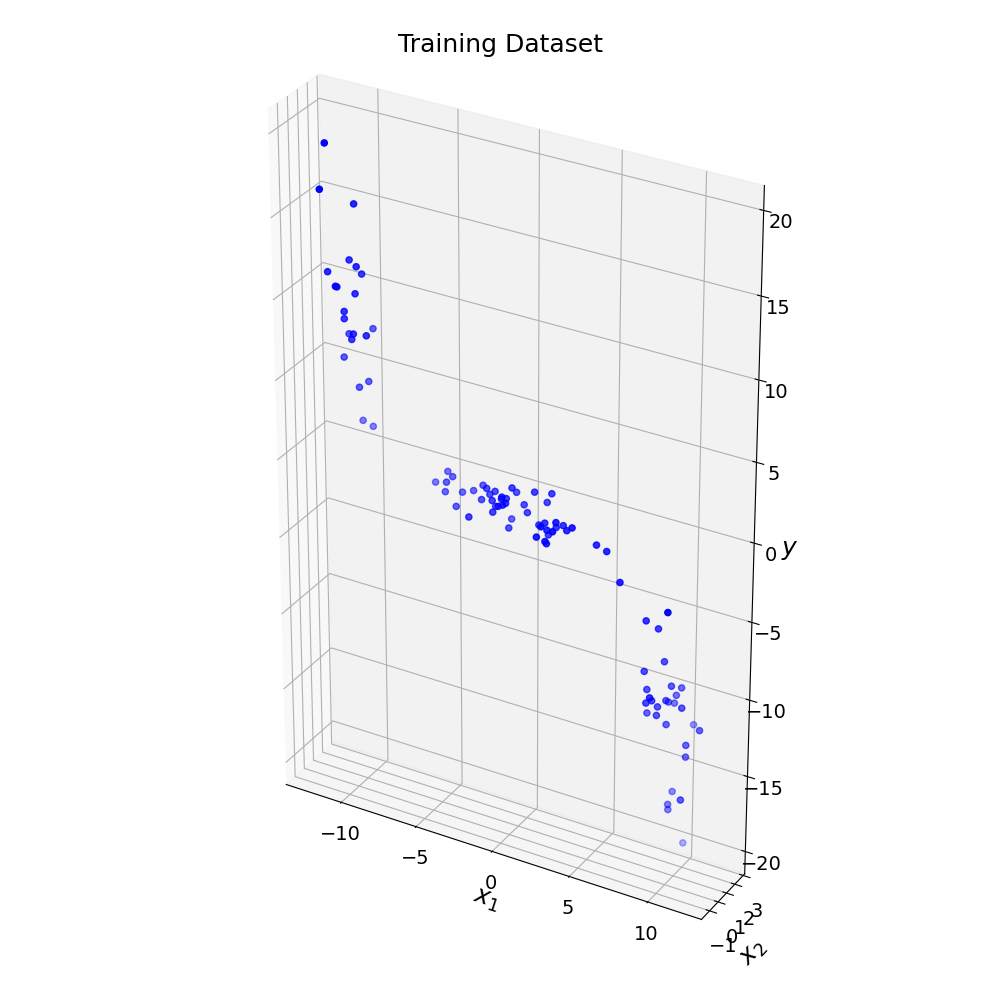

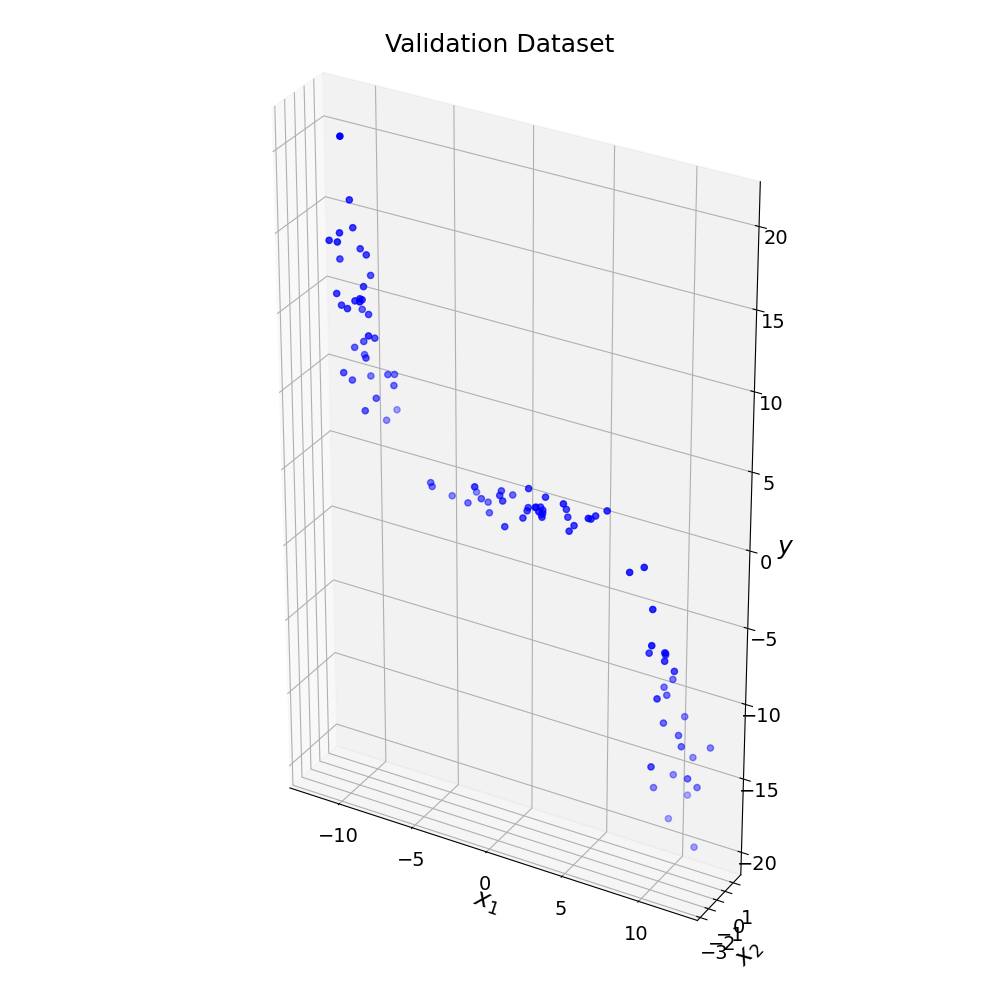

In [4]:
N_train = 100
N_valid = 1000

X_train, y_train = hw2_q2(N_train, "Training")
X_valid, y_valid = hw2_q2(N_train, "Validation")

We know that the best polynomial order to fit this function would be cubic $d=3$:

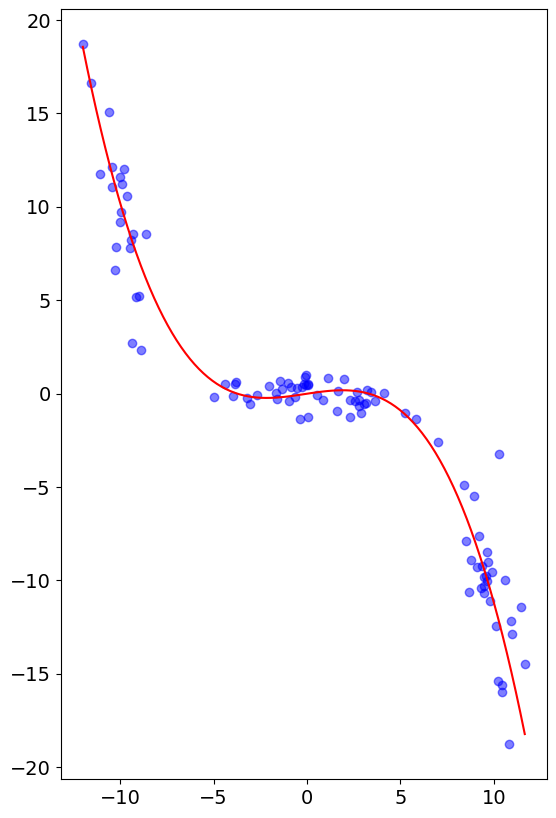

In [5]:
# Apply the phi transformation to create a Vandermonde matrix for order 3
X_train_poly = phi_transformation(X_train, d=3)
# Prepend column of ones
X_train_poly = np.column_stack((np.ones(N_train), X_train_poly))  
theta = mle_solution(X_train_poly, y_train)

# Create an ordered basis expansion of the training set for best line fit plotting
X0_train_bounds = np.linspace(min(X_train[:,0]), max(X_train[:,0]), N_train)
X1_train_bounds = np.linspace(min(X_train[:,1]), max(X_train[:,1]), N_train)
X_train_bounds = np.array((X0_train_bounds, X1_train_bounds)).T
X_train_bounds_poly = phi_transformation(X_train_bounds, d=3)
X_train_bounds_poly = np.column_stack((np.ones(N_train), X_train_bounds_poly))
y_train_predictions = X_train_bounds_poly.dot(theta)

# Only plot over the x1 feature-axis as that's visually sufficient
plt.ioff()
fig, ax = plt.subplots(figsize=(10, 10));
plt.ion()

ax.scatter(X_train[:, 0], y_train, marker='o', color='b', alpha=0.5);
ax.plot(X0_train_bounds, y_train_predictions, c='r', label="Best Fit Line");
ax.set_aspect('equal')

display(fig);
fig;

### Aside: Polynomial Transforms

The above `phi_transformation(X, d)` is forming a [Vandermonde](https://en.wikipedia.org/wiki/Vandermonde_matrix) matrix. It's worth highlighting that you should avoid using large orders $d$ with this basis expansion method. Vandermonde matrices become ill-conditioned rapidly and for large $d$, the MSE values will also be high since the ill-conditioned matrix inversion leads to poorly estimated parameters. Overall, it's a bad basis expansion choice. See [here](https://arxiv.org/abs/1504.02118) if you're more curious about this little aside.

What I propose doing instead, is using [sklearn's PolynomialFeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) class, which produces interaction features of the inputs in addition to their powers, i.e., products of degree distinct inputs $x_i$. See the sklearn doc linked for more information.

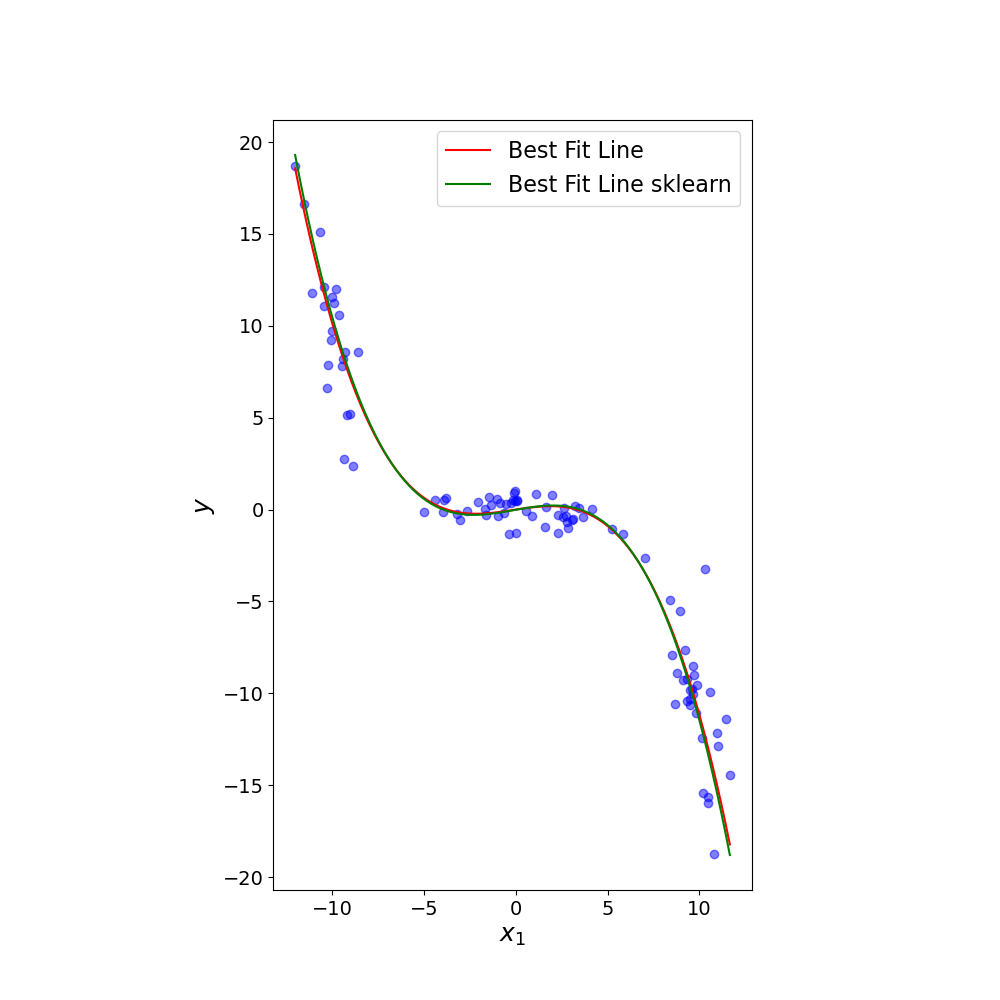

In [6]:
# The include_bias parameter will prepend the column of ones for us!
poly_features = PolynomialFeatures(degree=3, include_bias=True)
X_train_poly_sk = poly_features.fit_transform(X_train)

theta_sk = mle_solution(X_train_poly_sk, y_train)

# Use X bounds from before to transform the inputs 
X_train_bounds_poly_sk = poly_features.transform(X_train_bounds)
y_train_predictions_sk = X_train_bounds_poly_sk.dot(theta_sk)

# Only plot over the X0-axis as that's visually sufficient
ax.plot(X0_train_bounds, y_train_predictions_sk, c='g', label="Best Fit Line sklearn")
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$y$")
ax.legend()

plt.show()

With access to the validation set $\mathcal{D}_{valid}$, we can report on performance of the different models (degrees $d$) according to this data subset. In particular we will consider $d$ in the range $[1, 20]$:

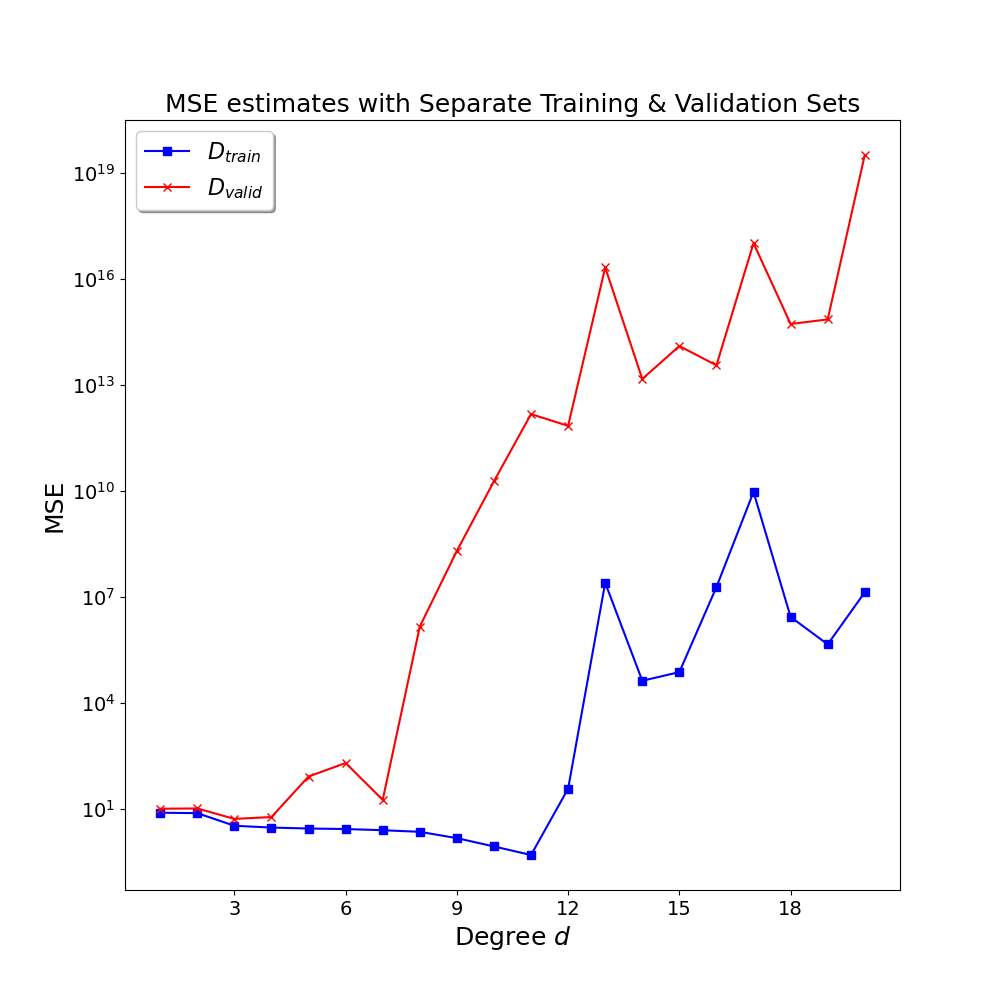

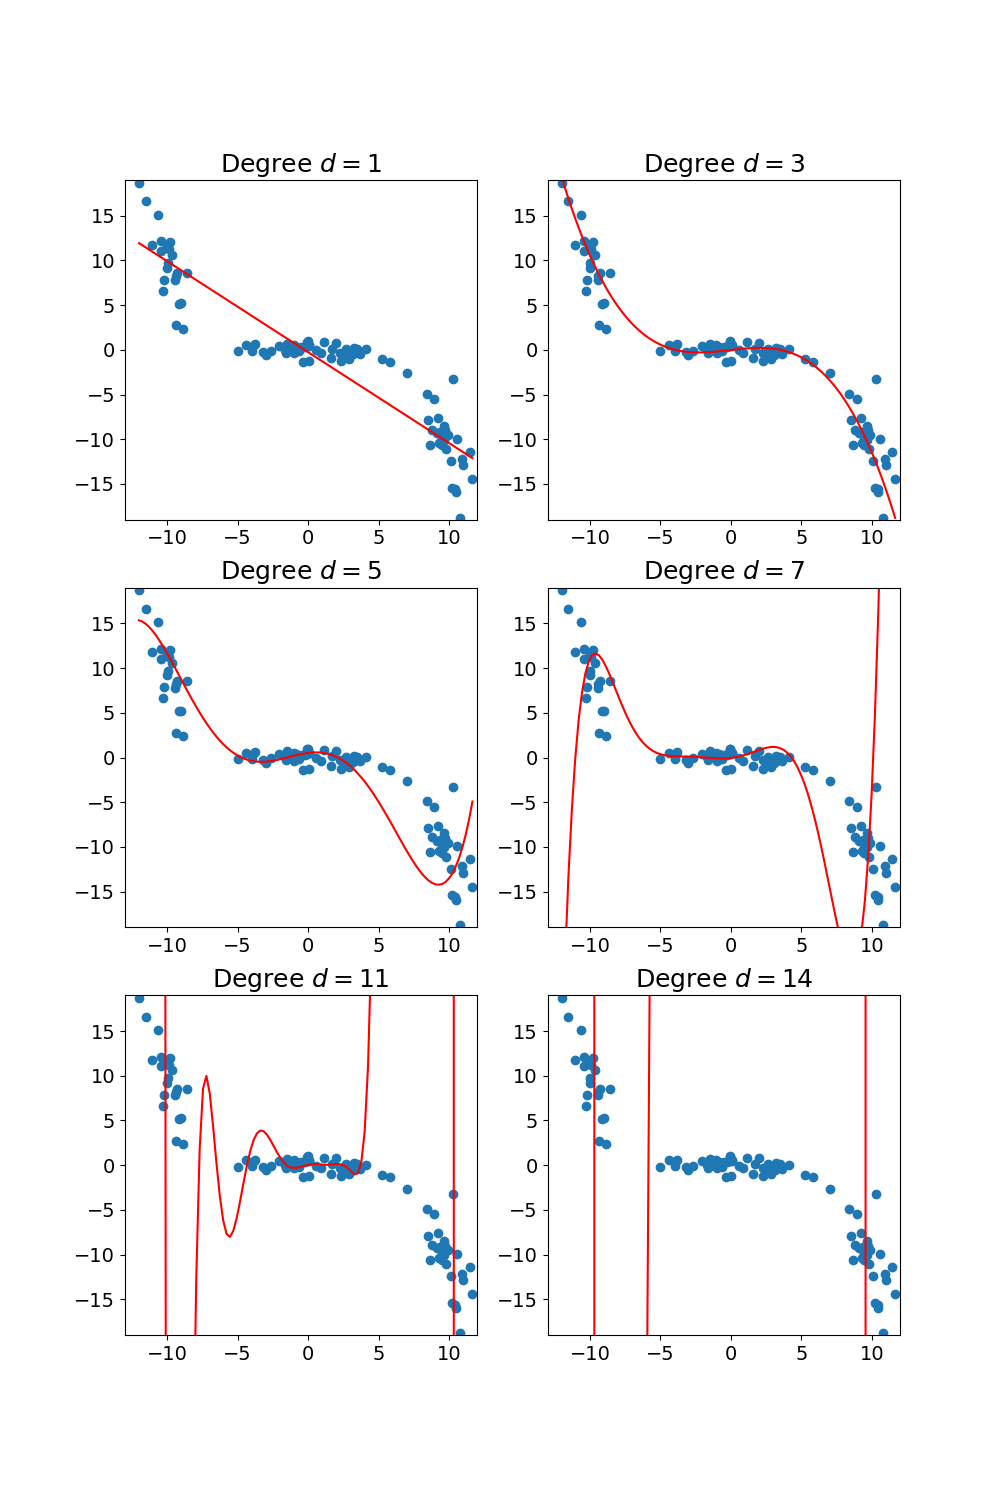

In [7]:
# Polynomial degrees ("hyperparameters") to evaluate 
degs = np.arange(1, 21, 1)
n_degs = np.max(degs)

# Allocate space for MSE train and validation error arrays
mse_train = np.empty(n_degs)
mse_valid = np.empty(n_degs)
# Store predictions per degree using ordered X samples for plotting best fit lines
y_train_preds_ordered = np.empty(n_degs, dtype=np.ndarray)
for deg in degs:
    # Create polynomial features for the training data
    poly_features = PolynomialFeatures(degree=deg, interaction_only=False, include_bias=True)
    X_train_poly = poly_features.fit_transform(X_train)
    # Compute the normal equation/optimal solution for this degree deg data
    theta = mle_solution(X_train_poly, y_train)
    
    # Make predictions on both the training and validation set
    y_train_pred = X_train_poly.dot(theta)

    # Use X bounds from before to transform the inputs for plots later
    X_train_bounds_poly = poly_features.transform(X_train_bounds)
    y_train_pred_ordered = X_train_bounds_poly.dot(theta)
    y_train_preds_ordered[deg - 1] = y_train_pred_ordered
    
    X_valid_poly = poly_features.transform(X_valid)
    y_valid_pred = X_valid_poly.dot(theta)
    
    # Record MSE as well
    mse_train[deg - 1] = mse(y_train_pred, y_train)
    mse_valid[deg - 1] = mse(y_valid_pred, y_valid)

# Plot MSE vs degree
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(degs, mse_train, color="b", marker="s", label=r"$D_{train}$")
ax.plot(degs, mse_valid, color="r", marker="x", label=r"$D_{valid}$")

# Use logarithmic y-scale as MSE values get very large
ax.set_yscale('log')
# Force x-axis for degrees to be integer
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.legend(loc='upper left', shadow=True)
plt.xlabel(r"Degree $d$")
plt.ylabel("MSE")
plt.title("MSE estimates with Separate Training & Validation Sets")
plt.show()

fig_reg = plt.figure(figsize=(10, 15))
X0_train_lim = (floor(np.min(X0_train_bounds)), ceil(np.max(X0_train_bounds)))
X1_train_lim = (floor(np.min(X1_train_bounds)), ceil(np.max(X1_train_bounds)))
y_train_lim = (floor(np.min(y_train)), ceil(np.max(y_train)))

chosen_degs = [1, 3, 5, 7, 11, 14]
i = 1
# Plot fit vs actual
for deg in chosen_degs:
    ax_reg = fig_reg.add_subplot(3, 2, i)#, projection='3d')
    ax_reg.scatter(X_train[:, 0], y_train)
    ax_reg.plot(X0_train_bounds, y_train_preds_ordered[deg - 1], 'r')
    ax_reg.set_xlim(X0_train_lim)
    ax_reg.set_ylim(y_train_lim)
    ax_reg.set_title(r"Degree $d={%d}$" % deg)
    i += 1

plt.show()

From the plots above, we can see the effect of <b>overfitting</b> as the optimal order on the training set is incorrectly thought to be $d=11$ (lowest MSE on $\mathcal{D}_{train}$). However, the optimal setting for our cubic input data is as we know, $d=3$, which is correctly identified by using a separate $\mathcal{D}_{valid}$ and evaluating model performance on this split set (see MSE vs Degree $d$ red line).

## K-fold Cross-validation (CV)

We know that for the generated dataset $\mathcal{D} = \{(\mathbf{x}^{(1)}, y^{(1)}), \ldots, (\mathbf{x}^{(N)}, y^{(N)})\}$, the best polynomial order to fit the line was $d=3$. Instead what if we were not able to intuit this? Moreover, imagine that $N$ is too small for us to split into $\mathcal{D}_{train}$ and $\mathcal{D}_{valid}$, we are thus unable to learn a sufficiently "fit" model, i.e., the model is too simple and underfitting due to lack of data.

Instead let's work with a single $\mathcal{D}$ by iteratively partitioning the dataset and simultaneously training models on this dataset, while also treating $d$ as a hyperparameter for optimal selection. For many settings, but especially small $N$ datasets, CV is a powerful and flexible solution to this hyperparameter selection process.

A review of the algorithm from your lecture notes is below:

1) Partition $\mathcal{D}$ into $\mathcal{D}_1, \mathcal{D}_2, \ldots, \mathcal{D}_K$ with equal partition sizes (or close)

2) for model $m \in \{1,\ldots,M\}$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; for fold $k \in \{1,\ldots,K\}$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  $\mathcal{D}_\text{valid-k} = \mathcal{D}_k \, ; \, \mathcal{D}_\text{train-k}=\mathcal{D}-\mathcal{D}_k$

&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\boldsymbol{\theta}^*_{m,k} = \displaystyle \mathop{\rm argmin}_{\boldsymbol{\theta}_m} \mathcal{L}_\text{train}(\boldsymbol{\theta}_m; \mathcal{D}_\text{train-k})$

&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;           $\epsilon_{m,k}=\mathcal{L}_\text{valid}(\boldsymbol{\theta}^*_{m,k};\mathcal{D}_\text{valid-k})$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;        $\displaystyle \epsilon_{m}=\frac{1}{K}\sum_{k=1}^K \epsilon_{m,k}$

3) "Best" model has smallest average error: $\displaystyle m^* = \mathop{\rm argmin}_{m\in\{1,\ldots,M\}}\epsilon_m$

4) Given $m^*$, train on entire dataset: $\displaystyle \boldsymbol{\theta}^*_{m^*} = \mathop{\rm argmin}_{\boldsymbol{\theta}_{m^*}} \mathcal{L}_\text{train}(\boldsymbol{\theta}_{m^*};\mathcal{D})$

For our least squares regression problem, we'll use the same RSS loss $\mathcal{L}_\text{RSS}(\boldsymbol{\theta})$ to train AND evaluate the models, i.e., $\mathcal{L}_\text{train}(\boldsymbol{\theta}) = \mathcal{L}_\text{valid}(\boldsymbol{\theta})$ during CV. Above I have written $\mathcal{D}_\text{valid-k}$ or similarly for 'train-k' in the K-fold iterations to highlight that these are k-splits of our single dataset $\mathcal{D}$. So the folds are over the $\mathbf{X}_{train}$ and $\mathbf{y}_{train}$ arrays in our case, assuming the corresponding $\mathbf{X}_{valid}$ and $\mathbf{y}_{valid}$ arrays are unavailable/undesirable due to underfitting risks...

The code below performs least squares polynomial fit assessment using 10-fold ($K=10$) CV, with the fold indices acquired from [sklearn's KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) class:

In [8]:
# Number of folds for CV
K = 10

# STEP 1: Partition the dataset into K approximately-equal-sized partitions
# Shuffles data before doing the division into folds (not necessary, but a good idea)
kf = KFold(n_splits=K, shuffle=True) 

# Allocate space for CV
# No need for training loss storage too but useful comparison
mse_valid_mk = np.empty((n_degs, K)) 
mse_train_mk = np.empty((n_degs, K)) # Indexed by model m, data partition k

# STEP 2: Try all polynomial orders between 1 (best line fit) and 21 (big time overfit) M=2
for deg in degs:
    # K-fold cross validation
    k = 0
    # NOTE that these subsets are of the TRAINING dataset
    # Imagine we don't have enough data available to afford another entirely separate validation set
    for train_indices, valid_indices in kf.split(X_train):
        # Extract the training and validation sets from the K-fold split
        X_train_k = X_train[train_indices]
        y_train_k = y_train[train_indices]
        X_valid_k = X_train[valid_indices]
        y_valid_k = y_train[valid_indices]
        
        # Train model parameters
        poly_train_features_cv = PolynomialFeatures(degree=deg, include_bias=True)
        X_train_k_poly = poly_train_features_cv.fit_transform(X_train_k)
        theta_mk = mle_solution(X_train_k_poly, y_train_k)
        
        # Validation fold polynomial transformation
        X_valid_k_poly = poly_train_features_cv.transform(X_valid_k)

        # Make predictions on both the training and validation set
        y_train_k_pred = X_train_k_poly.dot(theta_mk)        
        y_valid_k_pred = X_valid_k_poly.dot(theta_mk)

        # Record MSE as well for this model and k-fold
        mse_train_mk[deg - 1, k] = mse(y_train_k_pred, y_train_k)
        mse_valid_mk[deg - 1, k] = mse(y_valid_k_pred, y_valid_k)
        k += 1
            
# STEP 3: Compute the average MSE loss for that model (based in this case on degree d)
mse_train_m = np.mean(mse_train_mk, axis=1) # Model average CV loss over folds
mse_valid_m = np.mean(mse_valid_mk, axis=1) 

# +1 as the index starts from 0 while the degrees start from 1
optimal_d = np.argmin(mse_valid_m) + 1
print("The model selected to best fit the data without overfitting is: d={}".format(optimal_d))

# STEP 4: Re-train using your optimally selected model (degree=3) and deploy!!
# ...

The model selected to best fit the data without overfitting is: d=3


Plot the degree value $d$ vs MSE arising from the training and validation losses in CV to observe the trade-offs and rise of overfitting:

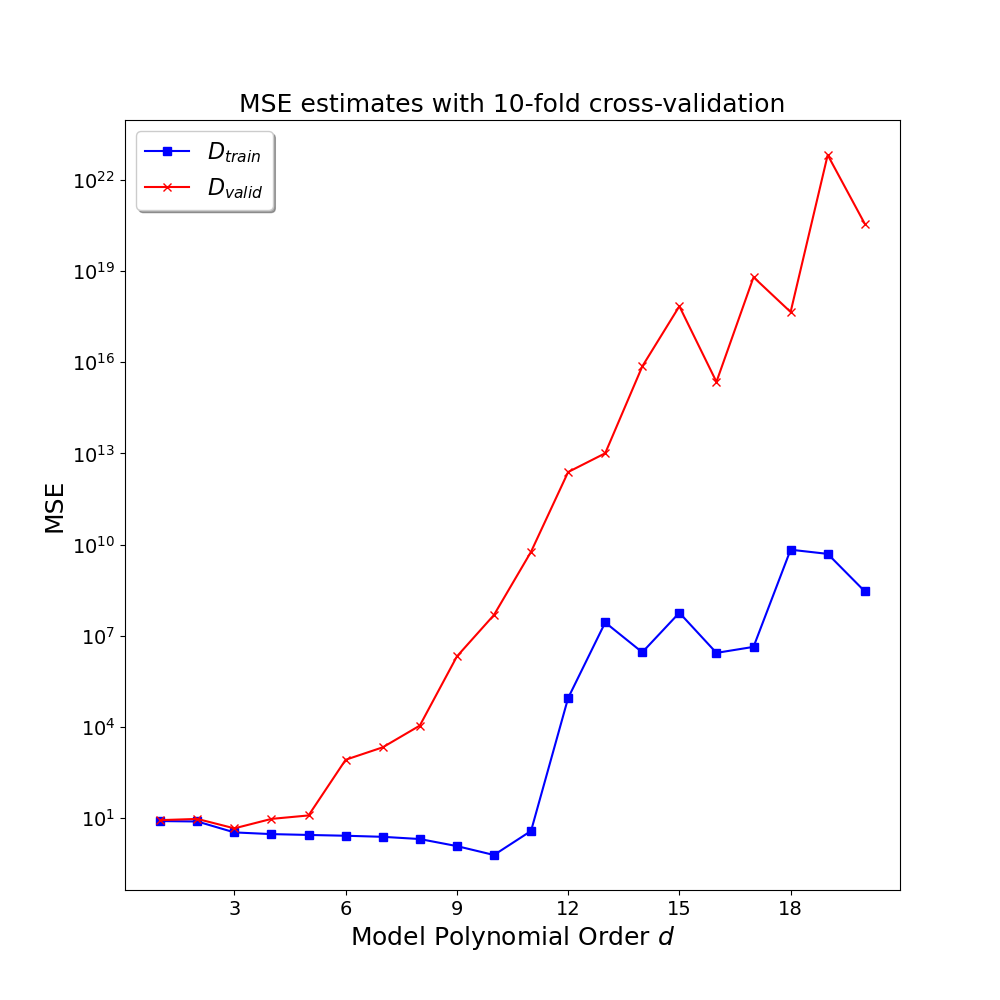

In [9]:
# Plot MSE vs degree
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(degs, mse_train_m, color="b", marker="s", label=r"$D_{train}$")
ax.plot(degs, mse_valid_m, color="r", marker="x", label=r"$D_{valid}$")

# Use logarithmic y-scale as MSE values get very large
ax.set_yscale('log')
# Force x-axis for degrees to be integer
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.legend(loc='upper left', shadow=True)
plt.xlabel(r"Model Polynomial Order $d$")
plt.ylabel("MSE")
plt.title("MSE estimates with {}-fold cross-validation".format(K))
plt.show()

We obtain the same general trend in favour of using $d=3$ with K-fold CV, as we did by evaluating on a separate $\mathcal{D}_{valid}$ entirely. As we did not use $\mathcal{D}_{valid}$ to select our model parameter, we could instead evaluate on this <b>test set</b> to evaluate generalization performance, rather than for model selection.

## References

Code adapted from <i>"linreg_poly_vs_degree.ipynb"</i> at:

@book{pml1Book,<br>
&emsp; author = "Kevin P. Murphy",<br>
&emsp; title = "Probabilistic Machine Learning: An introduction",<br>
&emsp; publisher = "MIT Press",<br>
&emsp; year = 2022,<br>
&emsp; url = "probml.ai"<br>
}